In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from scipy.optimize import minimize , basinhopping , curve_fit
from scipy.stats import poisson

In [21]:
# header = ['trade_id','price','quantity','order_id','timestamp','is_buyer_maker']
# df = pd.read_csv('.Data/BTCUSDT-trades-2023-05-26.csv',header=0 , names = header)
# df.head()
# header = ['trade_id','price','quantity','order_id','timestamp','is_buyer_maker']
# header = ['number','price','quantity','start trade','end trade','timestamp','s','is_buyer_maker']
# df = pd.read_csv('./BTCTUSD-aggTrades-2023-06-27.csv',header=0 , names = header)
# df.head()
header = ['trade_id','price','quantity','order_id','timestamp','is_buyer_maker']
df = pd.read_csv('./Data/BTCUSDT-trades-2023-05-31.csv',header=0 , names = header)
df.head()

,trade_id,price,quantity,order_id,timestamp,is_buyer_maker
0,3765419375,27680.0,0.400,11072.0000,1685491200110,True
1,3765419376,27680.0,0.006,166.0800,1685491200156,True
2,3765419377,27680.0,0.300,8304.0000,1685491200157,True
3,3765419378,27680.1,0.003,83.0403,1685491200244,False
4,3765419379,27680.1,0.003,83.0403,1685491203809,False


In [22]:
def closed_time_series(df, time_interval):
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df = df.set_index('timestamp')
    df['quantity'] = df['quantity'] * df['price']
    df['buy_quantity'] = np.where(df['is_buyer_maker'], df['quantity'], 0)
    df['sell_quantity'] = np.where(df['is_buyer_maker'], 0, df['quantity'])
    df = df.resample(str(time_interval)+'S').agg({'price':'last', 'quantity':'sum', 'buy_quantity':'sum', 'sell_quantity':'sum'})
    df['return'] = df['price'].diff()/ 0.1 # 0.1 is the tick size
    df = df.dropna()
    df['volatility'] = df['return'].rolling(600).std()
    return df

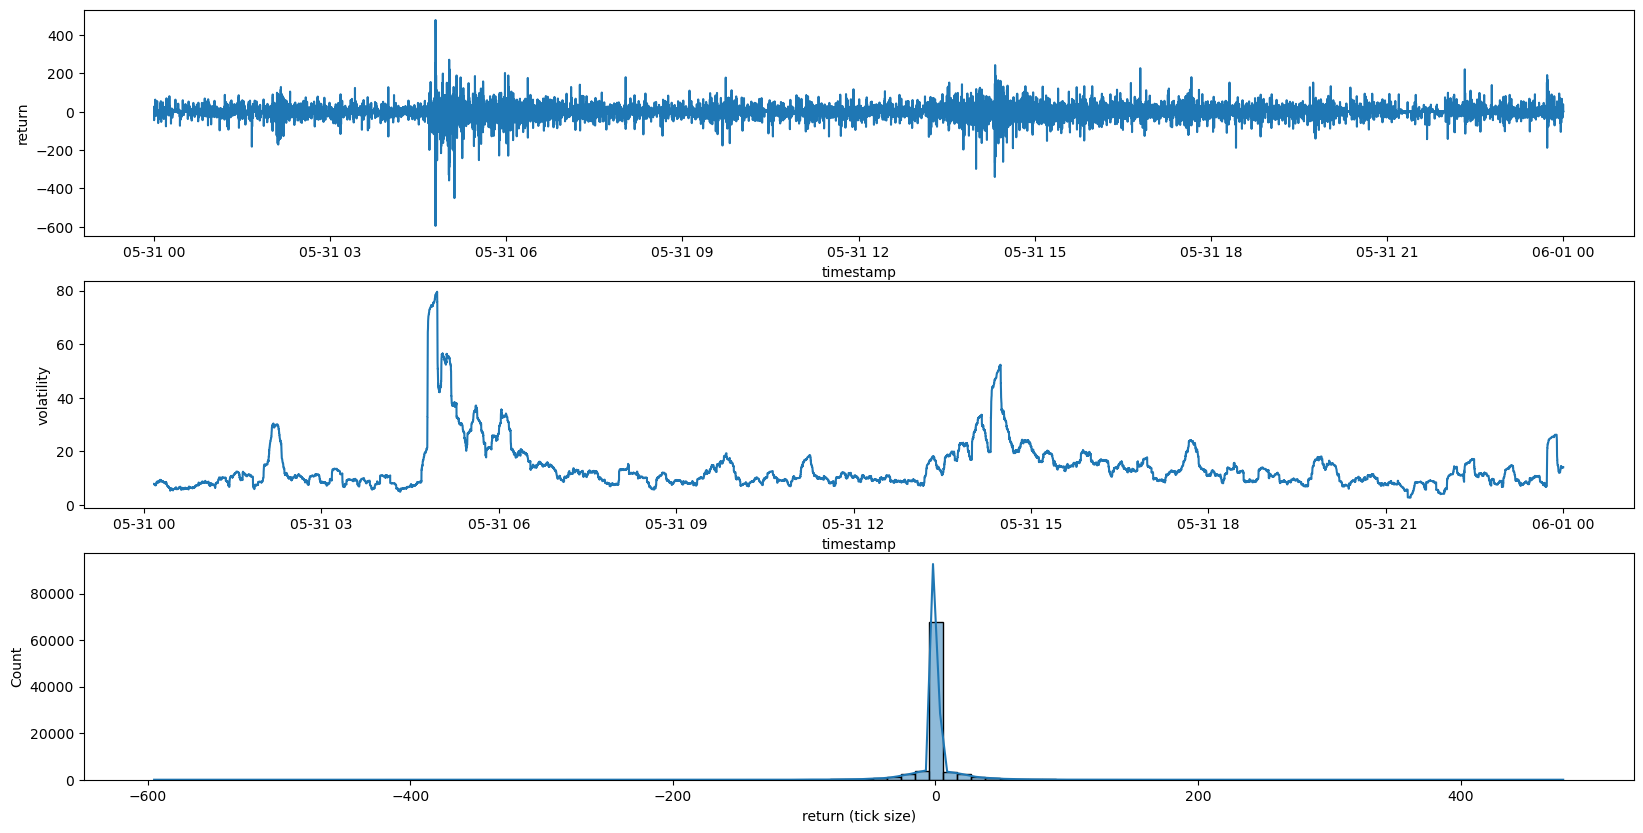

In [23]:
df_2 = closed_time_series(df, 1)
fig, axs = plt.subplots(3, 1, figsize=(20, 10))
sns.lineplot(data=df_2, x=df_2.index, y='return', ax=axs[0])
sns.lineplot(data=df_2, x=df_2.index, y='volatility', ax=axs[1])
sns.histplot(data=df_2, x='return', bins=100, ax=axs[2], kde=True)
axs[0].set_ylabel('return')
axs[1].set_ylabel('volatility')
axs[2].set_xlabel('return (tick size)')
plt.show()

# df_2 = df_2[:600]

# 1. Probability of Execution 

## 1.3 Probability of Execution

Now we can calculate the probability of execution of market making agent's limit order(LO).   
Let us assume that LO is executed if mid-price moves over her LO. It can be expressed as:  $ \mathbb {P(\Delta r > \delta)}$   


Then using the market impact model, we can rewrite the probability of execution as:
$$\begin{aligned}
\lambda(\delta) & =\Lambda P(\Delta p>\delta) \\
& =\Lambda P(\ln (Q)>K \delta) \\
& =\Lambda P(Q>\exp (K \delta)) \\
& =\Lambda \alpha x_{min}^{\alpha}\int_{\exp (K \delta)}^{\infty} x^{-1-\alpha} \mathrm{d} x \\
& =A \exp (-k \delta)
\end{aligned} $$
where $A = \Lambda  x_{min}^{\alpha}$ and $k = \alpha  K$ and $\Lambda$ is market order frequency of buy or sell .



In [27]:
def emprical_lambda_method_1(df,number_of_trials,max_tick_size,delta_t,tick_size):
    #row: number of trials , col: number of events
    # timestamp = df.index.values
    timestamp = df['timestamp'].values
    price = df['price'].values
    event_list_p = np.zeros((number_of_trials,max_tick_size))
    event_list_m = np.zeros((number_of_trials,max_tick_size))
    for i in range(1,max_tick_size):
        for j in range(1,number_of_trials):
            time_index = random.randint(0, int(len(df)/2))
            init_time = timestamp[time_index]
            init_price = price[time_index]
            time_diff = 0
            event_count_p = 0
            while time_diff < delta_t * 1000:
                price_diff = (price[time_index] - init_price)/tick_size
                time_diff = timestamp[time_index] - init_time
                if price_diff > i:
                    event_count_p += 1
                    break
                else:
                    pass 
                time_index += 1
            event_list_p[j][i] = event_count_p
    for i in range(1,max_tick_size):
        for j in range(1,number_of_trials):
            time_index = random.randint(0, int(len(df)/2))
            init_time = timestamp[time_index]
            init_price = price[time_index]
            time_diff = 0
            event_count_m = 0
            while time_diff < delta_t * 1000:
                price_diff = (price[time_index] - init_price)/tick_size
                time_diff = timestamp[time_index] - init_time
                if price_diff < -i:
                    event_count_m += 1
                    break
                else:
                    pass 
                time_index += 1
            event_list_m[j][i] = event_count_m
    mean_p = np.mean(event_list_p,axis=0)
    mean_m = np.mean(event_list_m,axis=0)
    return mean_p , mean_m

In [28]:
mean_p , mean_m = emprical_lambda_method_1(df,100,100,1,0.1)

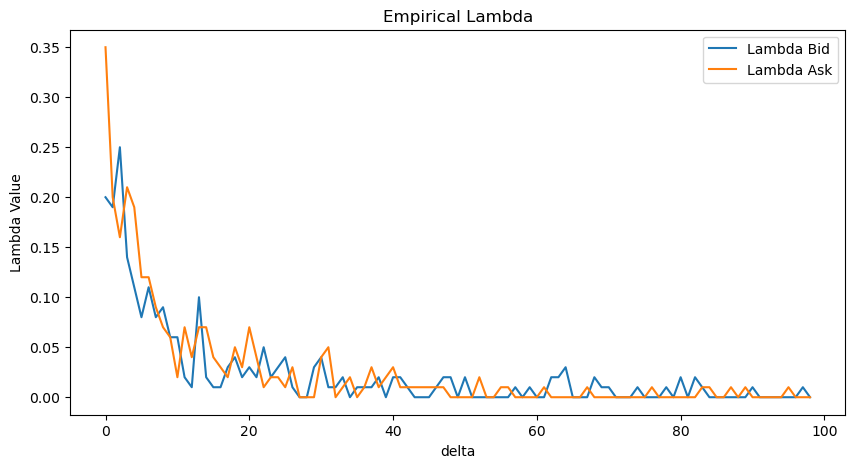

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(mean_p[1:] , label='Lambda Bid')
plt.plot(mean_m[1:] , label='Lambda Ask')
plt.title('Empirical Lambda')
plt.xlabel('delta')
plt.ylabel('Lambda Value')
plt.legend()
plt.show()

In [30]:
def fit_and_plot(column_mean_p,column_mean_m):
    x_p = np.arange(len(column_mean_p))
    y_p = column_mean_p

    x_m = np.arange(len(column_mean_m))
    y_m = column_mean_m

    def exponential_func(x, A, k):
        return A * np.exp(-k * x)

    popt_p, pcov_p = curve_fit(exponential_func, x_p, y_p)
    popt_m , pcov_m = curve_fit(exponential_func, x_m, y_m)

    plt.figure(figsize=(20, 5))
    plt.subplot(1,2,1)
    plt.plot(x_p, y_p,label='Data')
    plt.plot(x_p, exponential_func(x_p, *popt_p), 'r-', label='Fit: A=%5.3f, k=%5.3f' % tuple(popt_p))
    plt.xlabel('delta')
    plt.ylabel('lambda_p')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(x_m, y_m,label='Data')
    plt.plot(x_m, exponential_func(x_m, *popt_m), 'r-', label='Fit: A=%5.3f, k=%5.3f' % tuple(popt_m))
    plt.xlabel('delta')
    plt.ylabel('lambda_m')
    plt.legend()

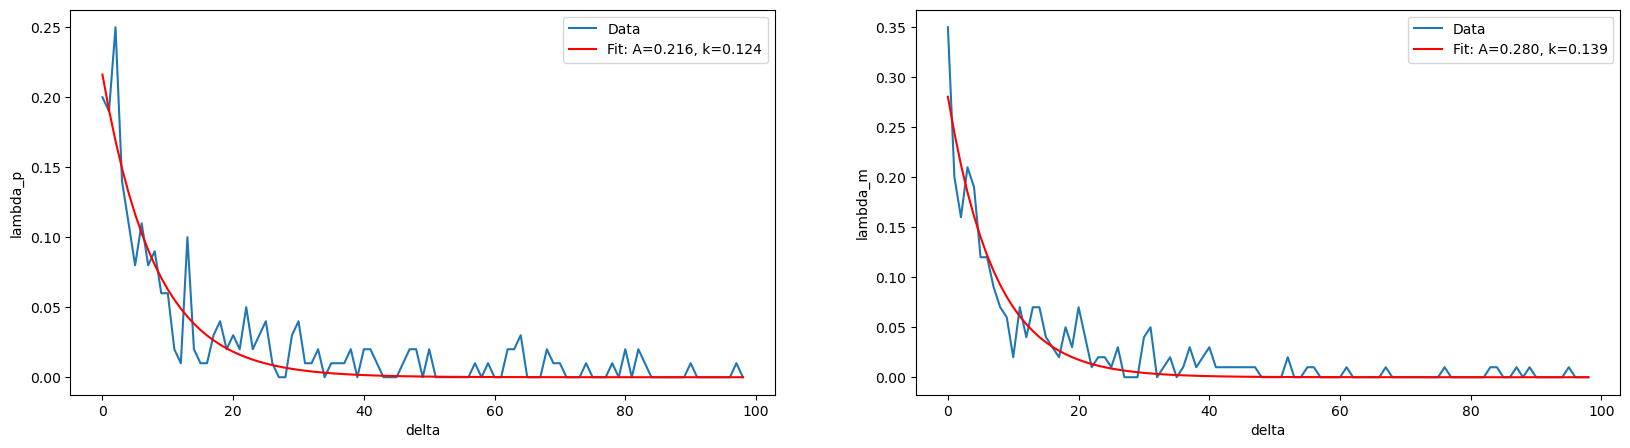

In [31]:
fit_and_plot(mean_p[1:],mean_m[1:])

# 2. Parameter Estimation of Mid-price model

## 2.1 Arithmetic Brownian Motion

Arithmetic Brownian Motion (ABM) is a stochastic process that describes the evolution of a stock price.   
The return of the stock at time $t$ is given by the following equation
$$dS_t = \mu dt + \sigma dW_t$$
Then we can solve SDE to get the stock price at time $t$:
$$S_t = S_0 + \mu t + \sigma W_t$$
Let $Y_t = S_t - S_0$, then $Y_t$ follows a normal distribution:
$$ Y_T \sim \mathcal{N}(\mu t,\sigma^2t)$$
where $S_0$ is the initial stock price, $\mu$ is the drift, $\sigma$ is the volatility, and $W_t$ is a standard Brownian motion. The drift and volatility are constant parameters.   

In [15]:
def mle_mu(data):
    mu = data['return'].mean() 
    return mu

def mle_sigma(data):
    sigma = data['return'].std()
    return sigma

In [16]:
mu_hat = mle_mu(df_2)
sigma_hat = mle_sigma(df_2)
print(f"mu: {mu_hat} tick")
print(f"sigma: {sigma_hat} tick")

mu: 0.02530026295217053 tick
sigma: 12.274733822742137 tick


In [17]:
def arithmeticBM(S0, mu, sigma, T, N):
    dt = T / N
    t = np.linspace(0, T, N)
    W = np.random.standard_normal(size=N)
    W = np.cumsum(W) * np.sqrt(dt)  # arithmetic brownian motion
    X = mu * t + sigma * W  # arithmetic brownian motion
    S = S0 + X
    return S

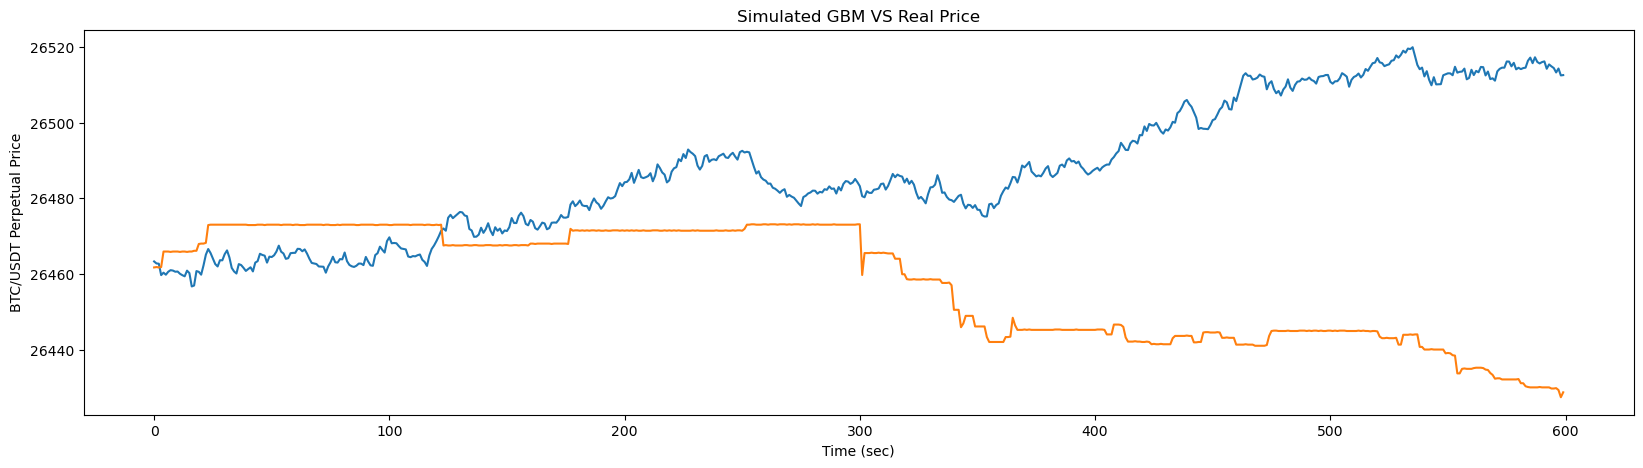

In [18]:
s = arithmeticBM(df_2['price'][0],mu_hat * 0.1,sigma_hat * 0.1,600,600) #tick to dollar
plt.figure(figsize=(20,5))
plt.plot(s)
plt.plot(np.array(df_2['price'][:600]))
plt.xlabel('Time (sec)')
plt.ylabel('BTC/USDT Perpetual Price')
plt.title('Simulated GBM VS Real Price')
plt.show()

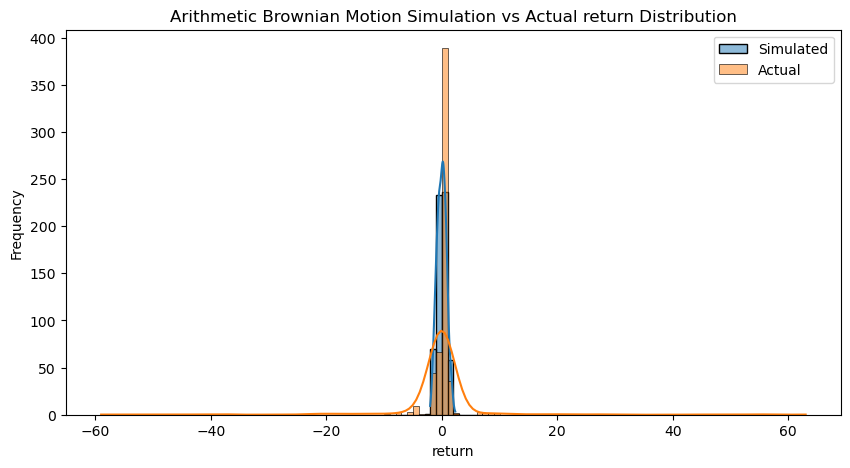

In [29]:
plt.figure(figsize=(10,5))
sns.histplot(np.diff(s),bins =20,binrange = (-10,10),label='Simulated',kde=True)
sns.histplot(df_2['return'],bins=20,binrange = (-10,10), label='Actual',kde=True)

plt.legend(loc='upper right')
plt.xlabel('return')
plt.ylabel('Frequency')
plt.title('Arithmetic Brownian Motion Simulation vs Actual return Distribution')
plt.show()

## 2.2 Jump diffusion 

In real world, the distribution of log return is not really normal.   
It is more likely to have a fat tail.  

Brownian Motion with jump diffusion follows SDE below:  
$$dS_t = \mu dt + \sigma dW_t + \xi dN_{t}^a - \xi dN_{t}^b$$   
where $\xi \gt 0$ and $dN_{t}^a$ is the number of jumps that occur in the interval $(t, t+dt)$.  
The jump size can be interpreted as adverse selection.

Let's solve the closed form solution of jump diffusion.  
In this paper, we assume that the jump size is constant. Let us apply Euler's discrete method to the SDE, we get:
$$ S_t = S_0 + \mu t + \sigma W_t + \sum_{i=0}^{N_t^a} \xi_i - \sum_{i=0}^{N_t^b} \xi_i $$ 

where $\xi_i$ is the jump size at time $t_i$ and $N_t$ is the number of jumps that occur in the interval $(0, t)$.    

Since we know number of jumps $N_t$ follows a Poisson distribution, we can get the distribution of $S_t$.  
If $X_t = S_t - S_0$, then by the law of the total probability, we have  
$$ \mathbb{P}(X_t = x) = \sum_{i,j = 0}^{\infin} \mathbb{P}(X_t = x | N_t^a = i , N_t^b = j) \mathbb{P}(N_t^a = i) \mathbb{P}(N_t^b = j) $$

The Likelihood function of the jump diffusion is given by:

$$ \mathcal{L}(\mu, \sigma, \xi^a,\xi^b) = \prod_{t=1}^{N} \sum_{i,j=0}^{\infin} \mathbb{P}(X_t = x_t | N_t^a = i , N_t^b = j) \mathbb{P}(N_t^a = i) \mathbb{P}(N_t^b = j) $$

Log likelihood function is given by:

$$ 
\begin{aligned}
\mathcal{l}(\mu, \sigma, \xi^a,\xi^b) = \sum_{t=1}^{N} \ln \sum_{i,j=0}^{\infin} \mathbb{P}(X_t = x_t | N_t^a = i , N_t^b = j) \mathbb{P}(N_t^a = i) \mathbb{P}(N_t^b = j)
\\

= \sum_{t=1}^{N} \ln (\sum_{i,j=0}^{\infin}\frac{1}{\sqrt{2 \pi \sigma^2 t}} \exp{(-\frac{(x - (\mu t + i \xi^a - j \xi^b))^2}{2\sigma^2 t})} \frac{\exp{(-\lambda ^a t)} (\lambda^a t)^{i} }{i!} \frac{\exp{(-\lambda ^b t)}(\lambda^b t)^{j}}{j!})

\end{aligned}
$$

where $ x_t$ is the observed mid-price at time $t_i$ and $N$ is the number of observations.  

- $Var[X_t | N_t^a = i , N_t^b = j] = \sigma^2 t
- $E[X_t | N_t^a = i , N_t^b = j] = \mu t + i \xi^a + j \xi^b$


Since we know hidden variable. We don't need to EM algorithm

In [15]:
def ABDJ(S0, mu, sigma,jump_intensity_ask,jump_intensity_bid,jump_size_ask, jump_size_bid ,T, N): # ABJD = Arithmetic Brownian Motion with Jumps
    dt = T / N
    t = np.linspace(0, T, N)
    W = np.random.standard_normal(size=N)
    W = np.cumsum(W) * np.sqrt(dt)
    J_ask = np.random.poisson(jump_intensity_ask * dt, size=N)  # jump process
    J_bid = np.random.poisson(jump_intensity_bid * dt, size=N)
    X = mu * t + sigma * W + np.cumsum(J_ask * jump_size_ask) - np.cumsum(J_bid * jump_size_bid) # arithmetic brownian motion with jumps
    S = S0 + X
    return S

In [16]:
def mle_jump_diffusion(param, data , jump_intensity_ask,jump_intensity_bid):
    mu = param[0]
    volatility = param[1]
    jump_size_ask = param[2]
    jump_size_bid = param[3]

    likelihood = []
    for t in range(1, len(data)):
        sum_i = 0
        for i in range(1, 10):
            sum_j = 0
            for j in range(1, 10):
                sum_j += (np.exp(- jump_intensity_ask *t) * (jump_intensity_ask *t) ** i / np.math.factorial(i)
                    * np.exp(- jump_intensity_bid *t) * (jump_intensity_bid *t) ** j / np.math.factorial(j)
                    * (1 / np.sqrt(2 * np.pi * (volatility ** 2 * t)))
                    * np.exp(- (data[t] - mu * t - i * jump_size_ask + j * jump_size_bid) ** 2 / (2 * (volatility ** 2 * t))))
            sum_i += sum_j
        if sum_i == 0:
            likelihood.append(1e-100)
        else:
            likelihood.append(sum_i)
    log_likelihood = np.sum(np.log(likelihood))
    return -log_likelihood

In [19]:
def mle_jump_diffusion_vec(param, data, jump_intensity_ask, jump_intensity_bid):
    mu, volatility, jump_size_ask, jump_size_bid = param

    t = np.arange(1, len(data))
    i = np.arange(1, 10)
    j = np.arange(1, 10)

    T, I, J = np.meshgrid(t, i, j, indexing='ij')

    exp1 = np.exp(-jump_intensity_ask * T) * ((jump_intensity_ask * T) ** I) / np.vectorize(np.math.factorial)(I)
    exp2 = np.exp(-jump_intensity_bid * T) * ((jump_intensity_bid * T) ** J) / np.vectorize(np.math.factorial)(J)
    exp3 = (1 / np.sqrt(2 * np.pi * (volatility ** 2 * T))) \
           * np.exp(- ((data[T] - mu * T - I * jump_size_ask + J * jump_size_bid) ** 2) / (2 * (volatility ** 2 * T)))
    likelihood = np.sum(exp1 * exp2 * exp3, axis=(1, 2))

    likelihood[likelihood < 1e-100] = 1e-100

    log_likelihood = np.sum(np.log(likelihood))

    return -log_likelihood


In [23]:
mu_0 = mle_mu(df_2) 
sigma_0 = mle_sigma(df_2)
jump_size_ask_0 = 30
jump_size_bid_0 = 30

args = (np.array(df_2['return']) , 20 , 20)

param = [mu_0,sigma_0,jump_size_ask_0,jump_size_bid_0]
bounds = ((-np.inf,np.inf),(0.1,np.inf),(-np.inf,np.inf),(-np.inf,np.inf))
res_lbfgsb = minimize(mle_jump_diffusion_vec, param, args = args,bounds=bounds,method='L-BFGS-B')
# res_bash = basinhopping(mle_jump_diffusion_vec, param, minimizer_kwargs={"args": args},niter=1000)

print('l-bfgs-b',res_lbfgsb.x)

l-bfgs-b [ 6.74289972  2.70633363 28.84685109 31.25712652]


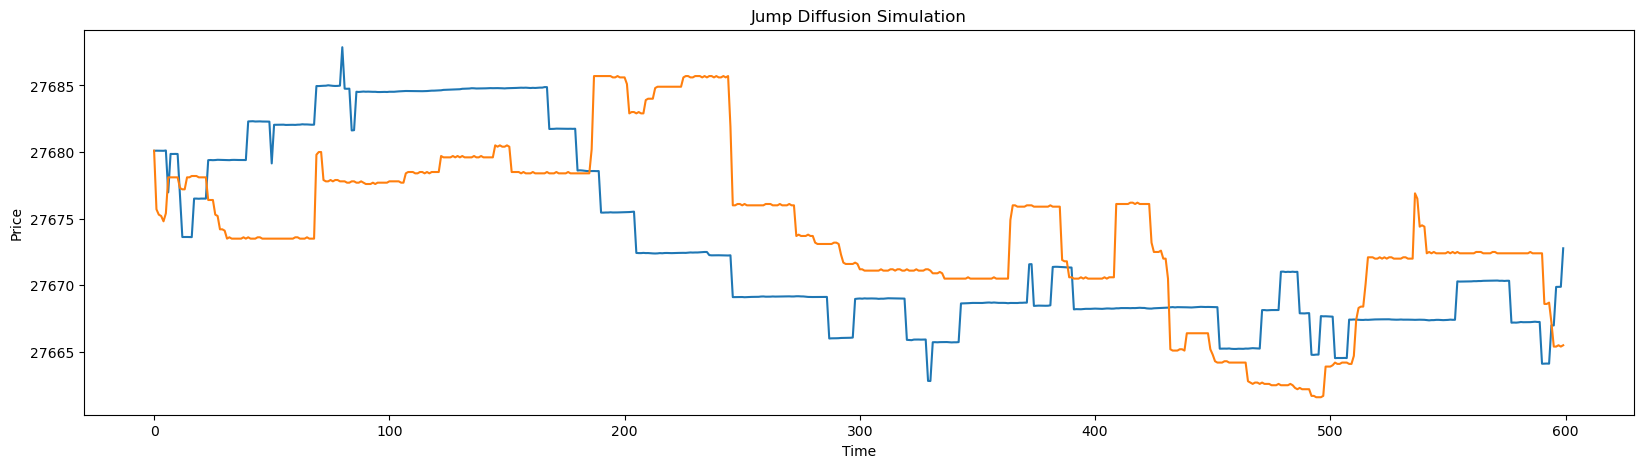

In [25]:
res = res_lbfgsb

mu_hat = res.x[0] * 0.1
sigma_hat = res.x[1] * 0.1
jump_size_ask_hat = res.x[2] * 0.1
jump_size_bid_hat = res.x[3] * 0.1

jump_intensity_ask = 20
jump_intensity_bid = 20

path = ABDJ(df_2['price'][0],mu_hat,sigma_hat,jump_intensity_ask,jump_intensity_bid,jump_size_ask_hat,jump_size_bid_hat,1,600)
plt.figure(figsize=(20,5))
plt.plot(path)
plt.plot(df_2['price'].values)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Jump Diffusion Simulation')
plt.show()

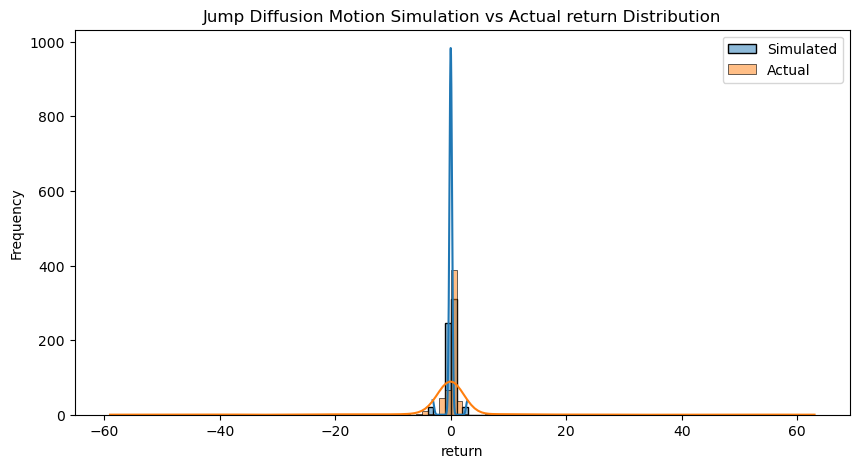

In [26]:
plt.figure(figsize=(10,5))
sns.histplot(np.diff(path),bins=20,binrange=(-10,10),label='Simulated',kde=True)
sns.histplot(df_2['return'],bins=20,binrange=(-10,10),label='Actual',kde=True)

plt.legend(loc='upper right')
plt.xlabel('return')
plt.ylabel('Frequency')
plt.title('Jump Diffusion Motion Simulation vs Actual return Distribution')
plt.show()

# 3. Optimal Market Making Strategy

The inventory of the market maker is the difference between the number of buy orders and the number of sell orders. i.e ) 
$$q_t = N_t^b - N_t^a$$  
where $N_t^{a}$ and $N_t^{b}$ are point processes.

Since our model is dimensionless BM. Thus, cash process is given by the following equation:  
$$d X_t = \left(1 + \delta_t^a \right )  dN_t^a - \left(1- \delta_t^b \right)d N_t^b$$   

Our goal is to find the maximize objective function below: 
$$\sup _{\left(\delta_t^a\right)_t,\left(\delta_t^b\right)_t \in \mathcal{A}} \mathbb{E}\left[-\exp \left(-\gamma\left(X_T+q_T S_T\right)\right)\right]$$
where $\gamma$ is the risk aversion parameter in CARA utility function , $\mathcal{A}$ is set of predictable processes bounded from below,.


## 3.1 HJB Equation

The HJB equation is given by the following equation:

$$ \partial t U + sup(\mathcal{L} U + F) = 0$$
where $\mathcal{L}$ is the infinitesimal generator of the process and $F$ is the running cost function.

The infinitesimal generator of the process is given by the following equation:
$$\mathcal{L} U = \frac{1}{2} \sigma^2 \partial_{s s}^2 U + \sup _{\delta^b} \lambda^b\left(\delta^b\right)\left[U\left(t, x-s+\delta^b, q+1, s\right)-U(t, x, q, s)\right] + \sup _{\delta^a} \lambda^a\left(\delta^a\right)\left[U\left(t, x+s+\delta^a, q-1, s\right)-U(t, x, q, s)\right]$$
where $\lambda^b$ and $\lambda^a$ are the intensity of the point process of buy and sell orders.

For $|q|<Q$ :
$$
\begin{gathered}
\partial_t u(t, x, q, s)+\frac{1}{2} \sigma^2 \partial_{s s}^2 u(t, x, q, s) \\
+\sup _{\delta^b} \lambda^b\left(\delta^b\right)\left[u\left(t, x-s+\delta^b, q+1, s\right)-u(t, x, q, s)\right] \\
+\sup _{\delta^a} \lambda^a\left(\delta^a\right)\left[u\left(t, x+s+\delta^a, q-1, s\right)-u(t, x, q, s)\right]=0
\end{gathered}
$$
For $q=Q$ :
$$
\begin{gathered}
\partial_t u(t, x, Q, s)+\frac{1}{2} \sigma^2 \partial_{s s}^2 u(t, x, Q, s) \\
+\sup _{\delta^a} \lambda^a\left(\delta^a\right)\left[u\left(t, x+s+\delta^a, Q-1, s\right)-u(t, x, Q, s)\right]=0
\end{gathered}
$$
For $q=-Q$ :
$$
\begin{gathered}
\partial_t u(t, x,-Q, s)+\frac{1}{2} \sigma^2 \partial_{s s}^2 u(t, x,-Q, s) \\
+\sup _{\delta^b} \lambda^b\left(\delta^b\right)\left[u\left(t, x-s+\delta^b,-Q+1, s\right)-u(t, x,-Q, s)\right]=0
\end{gathered}
$$
with the final condition:
$$
\forall q \in\{-Q, \ldots, Q\}, \quad u(T, x, q, s)=-\exp (-\gamma(x+q s))
$$

the solution of the HJB equation is given by the following equation:
$$ u(t, x, q, s)=\mathbb{E}\left[-\exp \left(-\gamma\left(X_T+q_T S_T\right)\right) | X_t=x, q_t=q, S_t=s\right]$$

## 3.2 Solution of HJB Equation

/var/folders/tc/pk8_r5g56wx6w90jrt_973rc0000gn/T/ipykernel_9685/3728074222.py:39: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


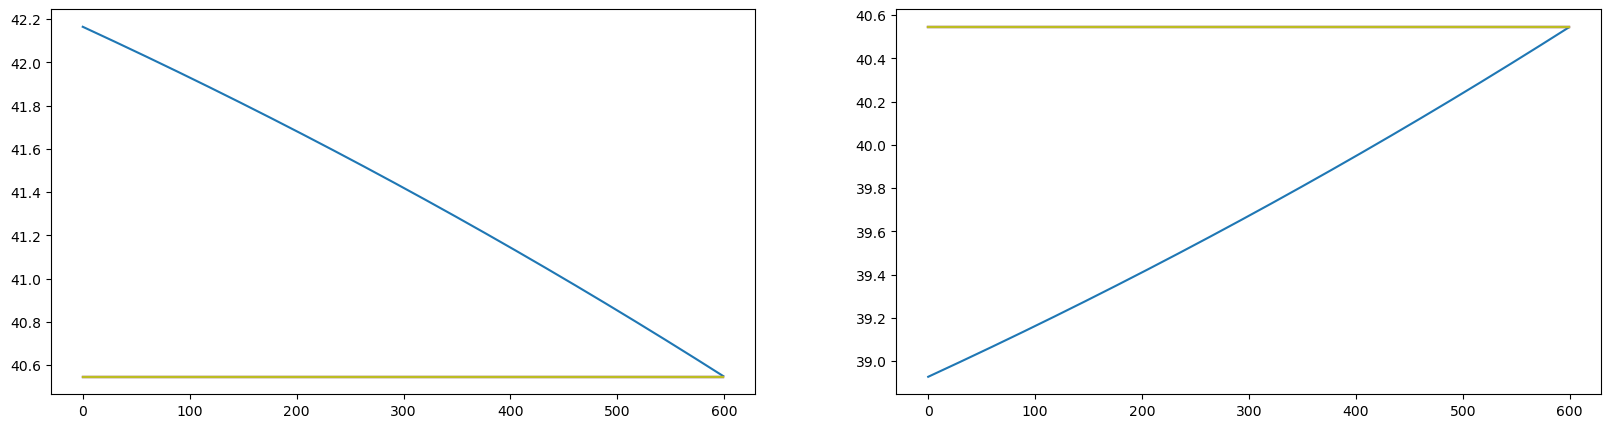

In [39]:
def create_matrix(Q, k, gamma, sigma, A, T, t):
    alpha = k/2 * gamma * sigma**2
    eta = A * (1 + gamma/k)**(-1 - k/gamma)
    diag = [alpha * q**2 for q in range(-Q, Q+1)]
    off_diag = [eta] * (2*Q)
    a = np.diag(diag, k=0)
    l = np.diag(off_diag, k=1)
    k = np.diag(off_diag, k=-1)
    M = a + l + k
    return np.exp(-M*(T-t))


def calculate_v(Q, k, gamma, sigma, A, T, t):
    vec = np.ones(2*Q+1).T
    M = create_matrix(Q, k, gamma, sigma, A, T, t)
    v = np.dot(M, vec)
    return v 


def calculate_delta_star(Q, k, gamma, sigma, A, T):
    delta_b_star = []
    delta_a_star = []
    for t in np.arange(0, T, 1/600):
        v = calculate_v(Q, k, gamma, sigma, A, T, t)
        delta_b_star.append([np.log(v[q]/v[q+1])/k + np.log(1+gamma/k)/gamma for q in range(0, 2*Q -1)])
        delta_a_star.append([np.log(v[q]/v[q-1])/k + np.log(1+gamma/k)/gamma for q in range(1, 2*Q)])
    return np.array(delta_b_star), np.array(delta_a_star)

Q = 5
MIN_ORDER = 1
gamma = 0.01
A = 1.4 #alpha_hat_buy * (MIN_ORDER**alpha_hat_buy) * market_order_frequency(df_2)/2
k = 0.02 #alpha_hat_buy * buy_market_impact
T = 1.0
t = 0.0

delta_b_star, delta_a_star = calculate_delta_star(Q, k, gamma, sigma_hat, A, T)
fig, ax = plt.subplots(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(delta_b_star)
plt.subplot(1, 2, 2)
plt.plot(delta_a_star)
plt.show()

References 
1. https://arxiv.org/pdf/1105.3115.pdf